In [1]:
#I am using my Python 3 11 scanorama env
! python --version

Python 3.11.9


In [55]:
import numpy as np
import pandas as pd

import scipy.sparse

import seaborn as sns

import math
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import patches
from shapely.geometry import Polygon, MultiPolygon, Point

import scanpy as sc

import anndata as an
import scanorama

from pathlib import Path

import squidpy as sq

import geopandas as gpd

import os
import warnings


from scipy.sparse import spmatrix


sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.0
-----
PIL                         10.3.0
annoy                       NA
anyio                       NA
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2025.01.31
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.5.0
dask_expr                   1.1.0
dask_image                  2023.08.1
datashader                  0.16.1
datatree                    0.0.14
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
executing                  

In [57]:
warnings.simplefilter("ignore")

## sample information 
VGN1e1 = late double ridge, VRT-A2a (P1 WT) <p>
VGN1e9 = late double ridge, VRT-A2b (P1 Pol) <p>
VGN1b6 = lemma primorida, VRT-A2a (P1 WT) <p>
VGN1b8 = lemma primorida, VRT-A2b (P1 Pol) <p>
VGN1a6 = terminal spikelet, VRT-A2a (P1 WT) <p>
VGN1a4 = terminal spikelet, VRT-A2b (P1 Pol) <p>
VGN1c2 = carpel extension round, VRT-A2a (P1 WT) <p>
VGN1c3 = carpel extension round, VRT-A2b (P1 Pol)


## reading in concatenated adata object 

In [58]:
# Define the path to the .h5ad file
file_path = 'leidenclustering/VRT_A2a_A2b_leiden_200genes_res1_indexed.h5ad'

# Read the file into an AnnData object
adata_spatial = sc.read_h5ad(file_path)

# Print the object to confirm it has been loaded correctly
print(adata_spatial)

AnnData object with n_obs × n_vars = 50731 × 200
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'dataset', 'clusters'
    uns: 'clusters', 'clusters_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'blank_genes', 'spatial'
    obsp: 'connectivities', 'distances'


## reading in individual sample adata objects 

In [59]:
#Read in the cleaned/filtered adata objects for my samples
# Define the filenames of the saved AnnData objects
adata_filenames = {
    "adata_VGN1a6": "qc/adata_VGN1a6_clean.h5ad",
    "adata_VGN1a4": "qc/adata_VGN1a4_clean.h5ad"
}

# Initialize a dictionary to store the loaded AnnData objects
loaded_adata_objects = {}

# Load each file and store it in the dictionary
for name, filename in adata_filenames.items():
    loaded_adata_objects[name] = sc.read_h5ad(filename)
    print(f"Loaded {name} from {filename}")

# Access the loaded AnnData objects
adata_VGN1a6 = loaded_adata_objects["adata_VGN1a6"]
adata_VGN1a4 = loaded_adata_objects["adata_VGN1a4"]

Loaded adata_VGN1a6 from qc/adata_VGN1a6_clean.h5ad
Loaded adata_VGN1a4 from qc/adata_VGN1a4_clean.h5ad


## Define function to process spatial info & make transect plots 

In [60]:
def process_spatial_data(
    segmentation_file,
    transcripts_file,
    cellgroups_file,
    adata,
    adata_spatial,
    rotation_angle=22,
    num_bins=30
):
    # Load data
    segmentation_df = gpd.read_parquet(segmentation_file)
    transcripts_df = pd.read_csv(transcripts_file)
    cellgroups = pd.read_csv(cellgroups_file, header=0, index_col=0)

    # Filter segmentation by cellgroups
    cell_list = list(map(str, cellgroups.index.tolist()))
    segmentation_df['EntityID'] = segmentation_df['EntityID'].astype(str)
    filtered_segmentation_df = segmentation_df[segmentation_df['EntityID'].isin(cell_list)]
    segmentation_df = gpd.GeoDataFrame(segmentation_df, geometry='Geometry')

    # Spatial join to filter transcripts within cells
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df,
        geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y'])
    )
    filtered_transcripts_gdf = gpd.sjoin(
        transcripts_gdf,
        filtered_segmentation_df[['EntityID', 'Geometry']],
        how='inner',
        predicate='within'
    ).drop(columns=['index_right', 'Unnamed: 0'], errors='ignore').drop_duplicates().reset_index(drop=True)

    transcripts_in_area = filtered_transcripts_gdf.copy()

    # Define genes and colors
    genes_of_interest = {
        'TraesCS7A02G175200': '#7CD250',  # VRT2
        'TraesCS7D02G120500': '#34618D',  # SEP1-4
    }

    # Prepare rotation matrix
    radians = math.radians(rotation_angle)
    cos_angle, sin_angle = math.cos(radians), math.sin(radians)
    rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

    # Center of the segmentation
    seg_cx, seg_cy = filtered_segmentation_df['Geometry'].centroid.x.mean(), filtered_segmentation_df['Geometry'].centroid.y.mean()

    # Rotate polygons
    rotated_patches_list = []
    rotated_polygons = []
    rotated_centroids = []
    for _, row in filtered_segmentation_df.iterrows():
        shape = row['Geometry']
        polys = shape.geoms if isinstance(shape, MultiPolygon) else [shape]
        for poly in polys:
            coords = np.array(poly.exterior.coords) - np.array([seg_cx, seg_cy])
            rotated_coords = np.dot(coords, rotation_matrix) + np.array([seg_cx, seg_cy])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.25)
            rotated_patches_list.append(patch)

    # Rotate transcript coordinates
    rotated_transcript_data = {}
    for gene, color in genes_of_interest.items():
        transcripts = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
        coords = transcripts[['global_x', 'global_y']].to_numpy() - np.array([seg_cx, seg_cy])
        rotated_coords = np.dot(coords, rotation_matrix) + np.array([seg_cx, seg_cy])
        rotated_transcript_data[gene] = {'x': rotated_coords[:, 0], 'y': rotated_coords[:, 1], 'color': color}

    # Bin assignment
    rotated_y_coords = [c.y for c in rotated_centroids]
    y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)
    y_bin_labels = list(range(1, num_bins + 1))

    def assign_y_bin(y):
        for i in range(len(y_bins) - 1):
            if y_bins[i] <= y < y_bins[i + 1]:
                return y_bin_labels[i]
        return None

    rotated_entity_bins_df = pd.DataFrame([
        {'EntityID': row.EntityID, 'Y_Bin': assign_y_bin(centroid.y)}
        for row, centroid in zip(filtered_segmentation_df.itertuples(), rotated_centroids)
    ]).drop_duplicates().reset_index(drop=True)

    # Convert adata to dataframe
    X_dense = adata.X.toarray() if isinstance(adata.X, scipy.sparse.spmatrix) else adata.X
    gene_expression_matrix = pd.DataFrame(X_dense, index=adata.obs_names, columns=adata.var_names).reset_index().rename(columns={'index': 'EntityID'})

    # Merge with Y bins
    gene_expression_combineddf = pd.merge(gene_expression_matrix, rotated_entity_bins_df, on='EntityID', how='inner').set_index('EntityID')

    # Extract clusters from adata_spatial
    df_cell_cluster_assignments = adata_spatial.obs[['clusters']].reset_index().rename(columns={'index': 'cell_id', 'clusters': 'cluster'})
    df_cell_cluster_assignments['cell_id'] = df_cell_cluster_assignments['cell_id'].astype(str)
    split_cols = df_cell_cluster_assignments['cell_id'].str.split('-', expand=True)
    df_cell_cluster_assignments['cell_id'] = split_cols[0]
    df_cell_cluster_assignments['sample'] = split_cols[1]
    df_cell_cluster_assignments.set_index('cell_id', inplace=True)

    # Final merge
    final_df = pd.merge(df_cell_cluster_assignments, gene_expression_combineddf, left_index=True, right_index=True, how='inner')

    # Compute bin-level averages for target genes
    data = final_df.drop(['cluster', 'sample'], axis=1).groupby('Y_Bin').mean().reset_index().drop(['Y_Bin'], axis=1).T.fillna(0)
    bindata = data.T.copy()
    bindata['y_bin'] = bindata.index + 1
    bindata = bindata[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'y_bin']]

    return {
        'rotated_patches_list': rotated_patches_list,
        'rotated_transcript_data': rotated_transcript_data,
        'y_bins': y_bins,
        'bin_centers': (y_bins[:-1] + y_bins[1:]) / 2,
        'y_bin_labels': y_bin_labels,
        'bindata': bindata,
        'y_min': y_min,
        'y_max': y_max
    }


In [61]:
def plot_spatial_results(results, title="Spatial Plot", save_path=None):
    fig, ax1 = plt.subplots(figsize=(20, 10))
    collection = PatchCollection(results['rotated_patches_list'], match_original=True)
    ax1.add_collection(collection)

    for gene, data in results['rotated_transcript_data'].items():
        ax1.scatter(data['x'], data['y'], color=data['color'], s=5, alpha=1, label=gene)

    for y_bin in results['y_bins']:
        ax1.axhline(y=y_bin, color='gray', linewidth=0.5, alpha=0.75, zorder=1)

    ax1.set_ylim([results['y_min'], results['y_max']])
    ax1.set_aspect('equal')

    bin_centers = results['bin_centers']
    ax1.set_yticks(bin_centers)
    ax1.set_xticks([])
    ax1.set_yticklabels(results['y_bin_labels'], size=15)
    ax1.set_xticklabels([])
    ax1.set_ylabel('Bins')
    ax1.set_title(title)
    ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)

    # Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=500, edgecolor='none')
        print(f"Plot saved to {save_path}")

    # Always show the plot
    plt.show()


In [62]:
def plot_transect_counts(results, title="Transect Counts Plot", save_path=None,
                         gene1='TraesCS7A02G175200', gene2='TraesCS7D02G120500'):
    bindata = results['bindata']
    bin_centers = results['bin_centers']
    y_min = results['y_min']
    y_max = results['y_max']
    y_bin_labels = results['y_bin_labels']

    fig, ax2 = plt.subplots(figsize=(5, 10))
    
    # Plot lines for both genes
    ax2.plot(bindata[gene1], bin_centers, label='VRT-A2', color='#7CD250', linewidth=3)
    ax2.plot(bindata[gene2], bin_centers, label='SEP1-4', color='#4077AE', linewidth=3)

    # Axis limits and labels
    buffer = 0.5
    ax2.set_ylim([y_min - buffer, y_max + buffer])
    ax2.set_xlim([0, max(bindata[gene1].max(), bindata[gene2].max()) * 1.1])
    ax2.set_xlabel('Normalised Counts per Cell', size=10)
    ax2.set_yticks(bin_centers)
    ax2.set_yticklabels(y_bin_labels, size=15)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.tick_params(axis='x', labelsize=15, labelrotation=45)

    # Clean up frame
    for spine in ['top', 'right']:
        ax2.spines[spine].set_visible(False)

    ax2.set_title(title)

    # Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', facecolor='white', edgecolor='none', dpi=300)
        print(f"Plot saved to {save_path}")

    # Always show
    plt.tight_layout()
    plt.show()

In [63]:
def compute_cluster_results_for_sample(
    sample_name: str,
    adata_sample,
    cells_in_spike_path: str,
    results_dict: dict
) -> dict:
    # Load the cell IDs specific to the spike
    cells_in_spike = pd.read_csv(cells_in_spike_path)
    cells_in_spike.rename(columns={cells_in_spike.columns[0]: 'cell_id'}, inplace=True)
    cells_in_spike['cell_id'] = cells_in_spike['cell_id'].astype(str)
    cell_id_list = cells_in_spike['cell_id'].tolist()

    # Convert AnnData matrix to dense
    if isinstance(adata_sample.X, spmatrix):
        X_dense = adata_sample.X.toarray()
    else:
        X_dense = adata_sample.X

    # Build gene expression dataframe
    cell_names = adata_sample.obs_names
    gene_names = adata_sample.var_names
    gene_expression_matrix = pd.DataFrame(data=X_dense, index=cell_names, columns=gene_names)
    gene_expression_matrix.index.name = 'EntityID'
    gene_expression_matrix = gene_expression_matrix.reset_index()

    # Filter for cells in spike
    filtered_combined_df = gene_expression_matrix.loc[gene_expression_matrix.index.isin(cell_id_list)]
    # Extract clusters from adata_spatial
    df_cell_cluster_assignments = adata_spatial.obs[['clusters']].reset_index().rename(columns={'index': 'cell_id', 'clusters': 'cluster'})
    df_cell_cluster_assignments['cell_id'] = df_cell_cluster_assignments['cell_id'].astype(str)
    split_cols = df_cell_cluster_assignments['cell_id'].str.split('-', expand=True)
    df_cell_cluster_assignments['cell_id'] = split_cols[0]
    df_cell_cluster_assignments['sample'] = split_cols[1]
    df_cell_cluster_assignments.rename(columns={'cell_id': 'EntityID'}, inplace=True)
    df_cell_cluster_assignments
    
    # Merge with rotated_entity_bins_df
    gene_expression_combineddf = pd.merge(
        gene_expression_matrix,
        df_cell_cluster_assignments,
        on='EntityID',
        how='inner'
    ).set_index('EntityID')

    filtered_combined_df = gene_expression_combineddf.loc[gene_expression_combineddf.index.isin(cell_id_list)]

    # Step 1: Binarize expression
    binary_expression_df = filtered_combined_df.drop(['cluster', 'sample'], axis=1).applymap(lambda x: 1 if x > 0 else 0)
    binary_expression_df['cluster'] = filtered_combined_df['cluster']
    binary_expression_df['sample'] = filtered_combined_df['sample']

    # Select relevant columns
    selected_df = binary_expression_df[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'cluster', 'sample']]

    # Step 2: Group by cluster and compute expression categories
    cluster_grouped_results = []
    for cluster, group in selected_df.groupby('cluster'):
        total = group.shape[0]
        co = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 1)].shape[0]
        vrt2 = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 0)].shape[0]
        sep = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 1)].shape[0]
        neither = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 0)].shape[0]

        cluster_grouped_results.append({
            'cluster': cluster,
            'total_cells_count': total,
            'co-expressed': co,
            'VRT2': vrt2,
            'SEP1-4': sep,
            'neither': neither,
            'percentage_coexpressing': (co / total) * 100 if total else 0,
            'percentage_vrt2_only': ((vrt2)/ total) * 100 if total else 0,
            'percentage_vrt2_total': ((vrt2 + co)/ total) * 100 if total else 0,
            'percentage_sep1_4_only': ((sep) / total) * 100 if total else 0,
            'percentage_sep1_4_total': ((sep + co)/ total) * 100 if total else 0,
            'percentage_neither': (neither / total) * 100 if total else 0,
            'sample': sample_name
        })

    # Store in the results dictionary
    cluster_results_df = pd.DataFrame(cluster_grouped_results).set_index('cluster')
    # Save both cluster_results_df and selected_df
    results_dict[sample_name] = {
        'cluster_results_df': cluster_results_df,
        'selected_df': selected_df
    }
    
    return results_dict


In [64]:
def report_and_plot_coexpression(
    cluster_results_df,
    selected_df,
    clusters_to_plot,
    cluster_labels,
    save_path=None
):
    # --- Report overall co-expression in selected_df ---
    selected_df2 = selected_df.drop(['sample'], axis=1)
    coexpressing_cells_count = selected_df2[
        (selected_df2['TraesCS7A02G175200'] == 1) & 
        (selected_df2['TraesCS7D02G120500'] == 1)
    ].shape[0]

    total_cells_count = selected_df2.shape[0]
    percentage_coexpressing = (coexpressing_cells_count / total_cells_count) * 100

    print("Number of cells co-expressing both genes:", coexpressing_cells_count)
    print("Percentage of cells co-expressing both genes:", percentage_coexpressing)

    # --- Prepare data for bar plot ---
    filtered_df = cluster_results_df.loc[clusters_to_plot]

    x = filtered_df.index  # Cluster IDs
    vrt2 = filtered_df['percentage_vrt2_only']
    co_expressed = filtered_df['percentage_coexpressing']
    sep1_4 = filtered_df['percentage_sep1_4_only']
    neither = filtered_df['percentage_neither']

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    plt.bar(x, vrt2, label='VRT2', edgecolor='#7CD250', color='#7CD250')
    plt.bar(x, co_expressed, bottom=vrt2, label='Co-expressed', edgecolor='#410052', color='#410052')
    plt.bar(x, sep1_4, bottom=vrt2 + co_expressed, label='SEP1-4', edgecolor='#4077AE', color='#4077AE')
    plt.bar(x, neither, bottom=vrt2 + co_expressed + sep1_4, label='Neither', edgecolor='white', color='white')

    plt.ylabel('Percentage Total Cell Count', size=12)
    plt.title('Stacked Bar Plot of Gene Expression by Selected Clusters')
    plt.legend(title='Expression Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Custom x-axis labels
    xtick_labels = [cluster_labels[cluster] for cluster in clusters_to_plot]
    plt.xticks(ticks=np.arange(len(x)), labels=xtick_labels, rotation=45, ha='right', size=12)
    plt.yticks(size=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg', facecolor='white', edgecolor='none', dpi=700)

    plt.show()


### Transect Plots of VRT-A2a Terminal Spikelet inflorescence

In [65]:
# Process first sample and store in dictionary
results_dict = {}

results_dict['VGN1a6'] = process_spatial_data(
    segmentation_file='cell_segmentation/VGN1a_region6_output/cellpose2_micron_space_VGN1a6.parquet',
    transcripts_file='cell_segmentation/VGN1a_region6_output/detected_transcripts.csv',
    cellgroups_file='VRT2analysis/cell_lists/24_10_24_allcellsinspike_VGN1a6.csv',
    adata=adata_VGN1a6,
    adata_spatial=adata_spatial,
    rotation_angle=22
)

Plot saved to VRT2analysis/figures/VGN1a6_VRT_SEP_transectplot.png


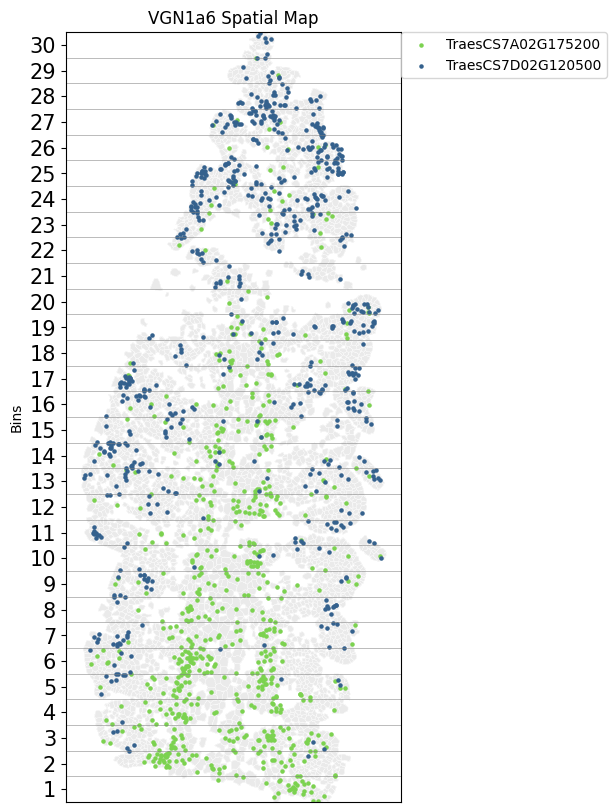

In [28]:
# Example: Plot VGN1a6
plot_spatial_results(results_dict['VGN1a6'], title="VGN1a6 Spatial Map", save_path='VRT2analysis/figures/VGN1a6_VRT_SEP_transectplot.png')

Plot saved to VRT2analysis/figures/VGN1a6_VRT_SEP_lineplot.svg


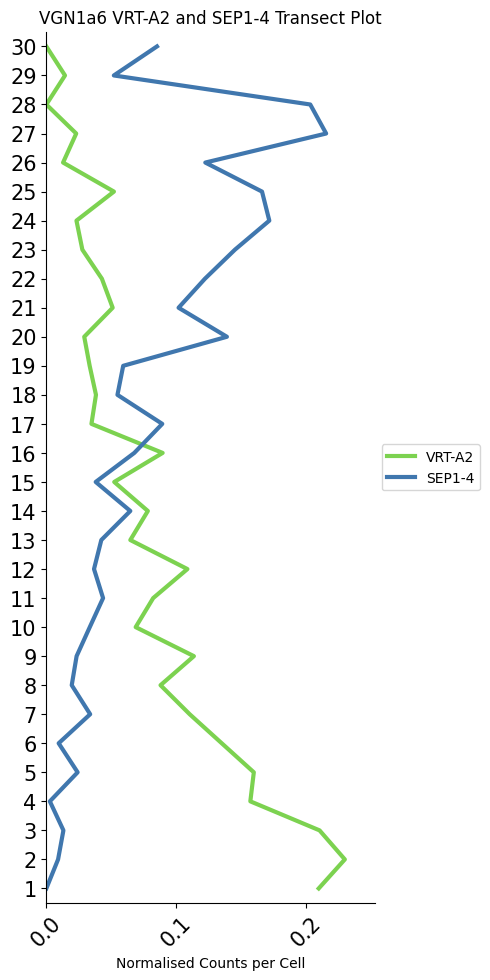

In [29]:
# Example using the results from VGN1a6
plot_transect_counts(
    results_dict['VGN1a6'],
    title="VGN1a6 VRT-A2 and SEP1-4 Transect Plot",
    save_path="VRT2analysis/figures/VGN1a6_VRT_SEP_lineplot.svg"
)


In [67]:
df = results_dict['VGN1a6']['bindata']

# Define gene name
gene = 'TraesCS7A02G175200'

lower_avg = df[df['y_bin'] <= 10][gene].mean()
upper_avg = df[(df['y_bin'] >= 11) & (df['y_bin'] <= 30)][gene].mean()
fold_change = lower_avg / upper_avg

print(f"Mean expression in bins 1–10 is {fold_change:.2f}x higher than in bins 11-30.")

Mean expression in bins 1–10 is 3.46x higher than in bins 11-30.


Number of cells co-expressing both genes: 34
Percentage of cells co-expressing both genes: 0.7240204429301533


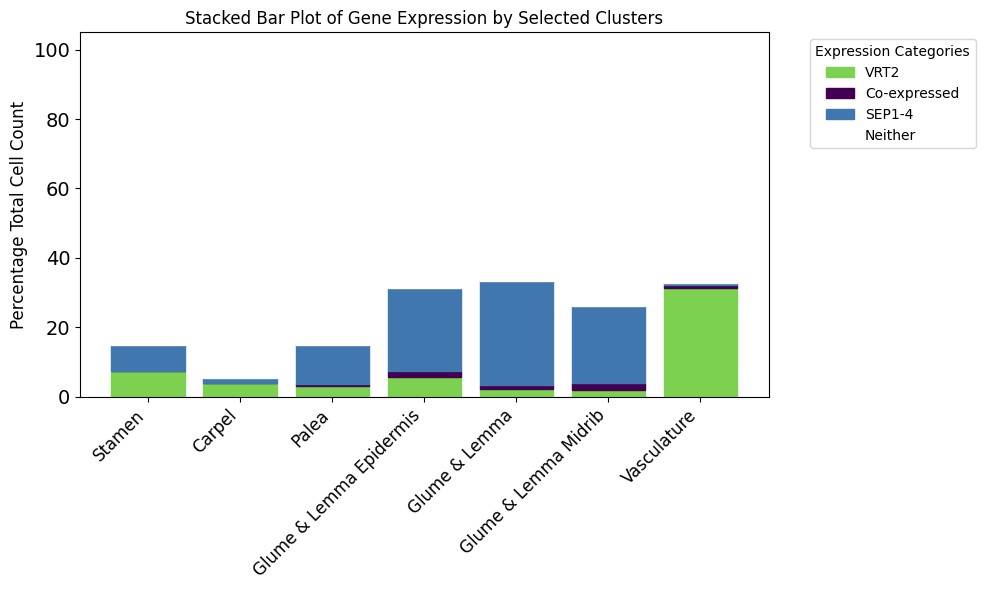

In [49]:
results_dict = {}
results_dict = compute_cluster_results_for_sample(
    sample_name='VGN1a6',
    adata_sample=adata_VGN1a6,
    cells_in_spike_path='VRT2analysis/cell_lists/24_10_24_allcellsinspike_VGN1a6.csv',
    results_dict=results_dict
)

cluster_labels = {
    '3': 'Vasculature',
    '1': 'Glume & Lemma Epidermis',
    '2': 'Glume & Lemma',
    '8': 'Glume & Lemma Midrib',
    '15': 'Palea',
    '10': 'Stamen',
    '14': 'Stamen epidermis',
    '16': 'Carpel'
}

clusters_to_plot = ['10', '16', '15', '1', '2', '8', '3']

report_and_plot_coexpression(
    cluster_results_df=results_dict['VGN1a6']['cluster_results_df'],
    selected_df=results_dict['VGN1a6']['selected_df'],
    clusters_to_plot=clusters_to_plot,
    cluster_labels=cluster_labels,
    save_path='VRT2analysis/figures/VGN1a6_VRTSEP_bargraph.svg'
)


In [50]:
results_dict['VGN1a6']['cluster_results_df'].to_csv('VRT2analysis/VGN1a6_VRT_SEP_CoExpression.csv', index=False)
results_dict['VGN1a6']['cluster_results_df']

,total_cells_count,co-expressed,VRT2,SEP1-4,neither,percentage_coexpressing,percentage_vrt2_only,percentage_vrt2_total,percentage_sep1_4_only,percentage_sep1_4_total,percentage_neither,sample
cluster,,,,,,,,,,,,
0,1171,10,134,81,946,0.853971,11.443211,12.297182,6.917165,7.771136,80.785653,VGN1a6
1,335,6,19,80,230,1.791045,5.671642,7.462687,23.880597,25.671642,68.656716,VGN1a6
2,270,3,6,81,180,1.111111,2.222222,3.333333,30.000000,31.111111,66.666667,VGN1a6
3,634,5,199,4,426,0.788644,31.388013,32.176656,0.630915,1.419558,67.192429,VGN1a6
4,631,0,26,77,528,0.000000,4.120444,4.120444,12.202853,12.202853,83.676704,VGN1a6
5,247,1,30,10,206,0.404858,12.145749,12.550607,4.048583,4.453441,83.400810,VGN1a6
6,246,5,29,50,162,2.032520,11.788618,13.821138,20.325203,22.357724,65.853659,VGN1a6
7,233,0,11,14,208,0.000000,4.721030,4.721030,6.008584,6.008584,89.270386,VGN1a6
8,157,3,3,35,116,1.910828,1.910828,3.821656,22.292994,24.203822,73.885350,VGN1a6


### Transect Plots of VRT-A2b Terminal Spikelet inflorescence

In [32]:
# Process first sample and store in dictionary
results_dict = {}

results_dict['VGN1a4'] = process_spatial_data(
    segmentation_file='cell_segmentation/VGN1a_region4_output/cellpose2_micron_space_VGN1a4.parquet',
    transcripts_file='cell_segmentation/VGN1a_region4_output/detected_transcripts_VGN1a4.csv',
    cellgroups_file='VRT2analysis/cell_lists/24_10_24_allcellsinspike_VGN1a4.csv',
    adata=adata_VGN1a4,
    adata_spatial=adata_spatial,
    rotation_angle=22
)

Plot saved to VRT2analysis/figures/VGN1a4_VRT_SEP_transectplot.png


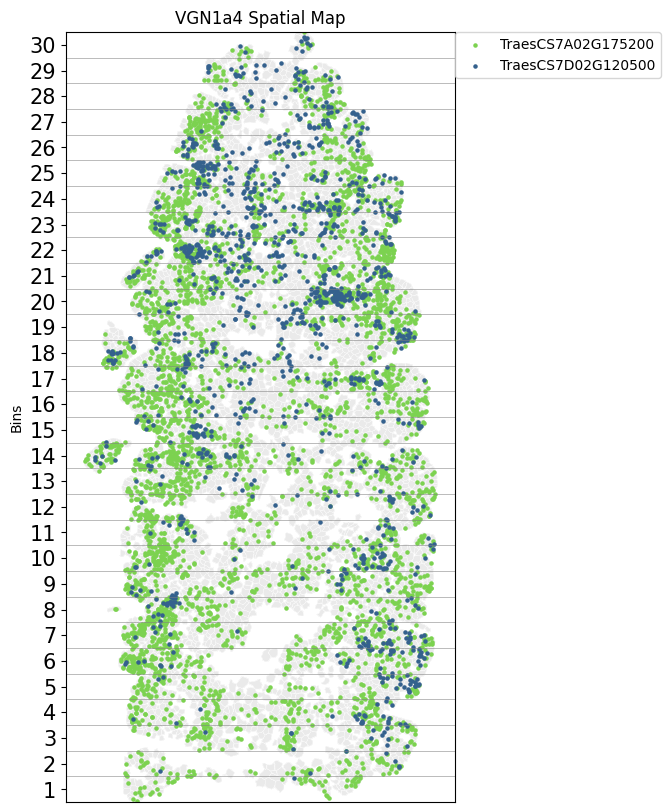

In [33]:
# Example: Plot VGN1a4
plot_spatial_results(results_dict['VGN1a4'], title="VGN1a4 Spatial Map", save_path='VRT2analysis/figures/VGN1a4_VRT_SEP_transectplot.png')

Plot saved to VRT2analysis/figures/VGN1a4_VRT_SEP_lineplot.svg


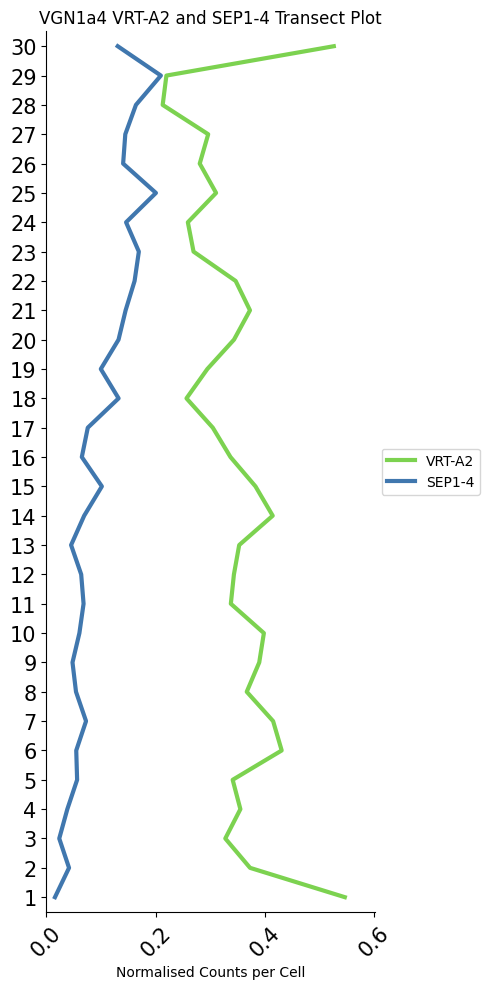

In [34]:
# Example using the results from VGN1a6
plot_transect_counts(
    results_dict['VGN1a4'],
    title="VGN1a4 VRT-A2 and SEP1-4 Transect Plot",
    save_path="VRT2analysis/figures/VGN1a4_VRT_SEP_lineplot.svg"
)


Number of cells co-expressing both genes: 483
Percentage of cells co-expressing both genes: 8.221276595744682


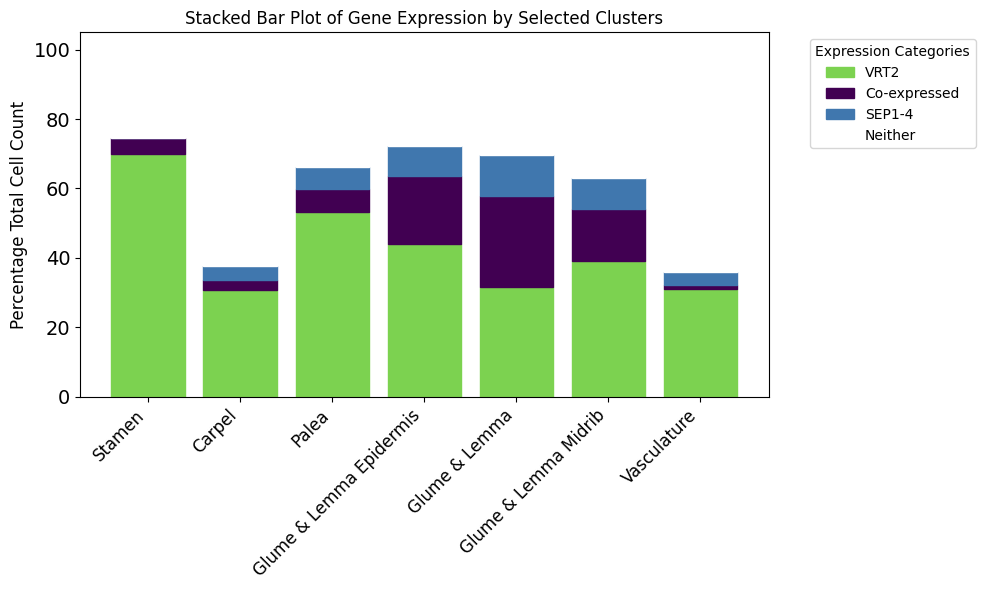

In [51]:
results_dict = {}
results_dict = compute_cluster_results_for_sample(
    sample_name='VGN1a4',
    adata_sample=adata_VGN1a4,
    cells_in_spike_path='VRT2analysis/cell_lists/24_10_24_allcellsinspike_VGN1a4.csv',
    results_dict=results_dict
)

cluster_labels = {
    '3': 'Vasculature',
    '1': 'Glume & Lemma Epidermis',
    '2': 'Glume & Lemma',
    '8': 'Glume & Lemma Midrib',
    '15': 'Palea',
    '10': 'Stamen',
    '14': 'Stamen epidermis',
    '16': 'Carpel'
}

clusters_to_plot = ['10', '16', '15', '1', '2', '8', '3']

report_and_plot_coexpression(
    cluster_results_df=results_dict['VGN1a4']['cluster_results_df'],
    selected_df=results_dict['VGN1a4']['selected_df'],
    clusters_to_plot=clusters_to_plot,
    cluster_labels=cluster_labels,
    save_path='VRT2analysis/figures/VGN1a4_VRTSEP_bargraph.svg'
)


In [53]:
results_dict['VGN1a4']['cluster_results_df'].to_csv('VRT2analysis/VGN1a4_VRT_SEP_CoExpression.csv', index=False)
results_dict['VGN1a4']['cluster_results_df']

,total_cells_count,co-expressed,VRT2,SEP1-4,neither,percentage_coexpressing,percentage_vrt2_only,percentage_vrt2_total,percentage_sep1_4_only,percentage_sep1_4_total,percentage_neither,sample
cluster,,,,,,,,,,,,
0,1250,67,329,112,742,5.360000,26.320000,31.680000,8.960000,14.320000,59.360000,VGN1a4
1,421,83,185,36,117,19.714964,43.942993,63.657957,8.551069,28.266033,27.790974,VGN1a4
2,430,113,136,51,130,26.279070,31.627907,57.906977,11.860465,38.139535,30.232558,VGN1a4
3,440,5,136,17,282,1.136364,30.909091,32.045455,3.863636,5.000000,64.090909,VGN1a4
4,522,14,136,37,335,2.681992,26.053640,28.735632,7.088123,9.770115,64.176245,VGN1a4
5,432,19,103,36,274,4.398148,23.842593,28.240741,8.333333,12.731481,63.425926,VGN1a4
6,440,71,161,45,163,16.136364,36.590909,52.727273,10.227273,26.363636,37.045455,VGN1a4
7,630,25,373,8,224,3.968254,59.206349,63.174603,1.269841,5.238095,35.555556,VGN1a4
8,133,20,52,12,49,15.037594,39.097744,54.135338,9.022556,24.060150,36.842105,VGN1a4
